<a href="https://colab.research.google.com/github/iraidaantropova/machine_L/blob/main/HW4_SinitsaI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 4. Uplift-моделирование. Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.



In [1]:
!pip install scikit-uplift catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки


In [5]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)



In [6]:
#категориальные признаки

df.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [7]:
df.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [8]:
cat_features=['zip_code','channel']

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [16]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from catboost import CatBoostClassifier

In [17]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

,model,uplift@10%,uplift@20%


In [18]:
parameters_cb = {
     'n_estimators': [100, 150, 200, 600, 1000],
     'max_depth': np.arange(2, 10, 2),
 }
clf = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        cat_features=cat_features, random_state=0, silent=True
    ),
    param_distributions=parameters_cb,
    scoring='roc_auc',
    cv=5
)
clf.fit(X_train, y_train)
clf.best_params_

{'n_estimators': 600, 'max_depth': 2}

In [19]:
sm = SoloModel(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([0.08123835, 0.05105195, 0.04338113, ..., 0.0382193 , 0.06165623,
       0.09679182])

In [21]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_10

0.07400641502219765

In [22]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_20

0.07173885336788666

In [23]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [24]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

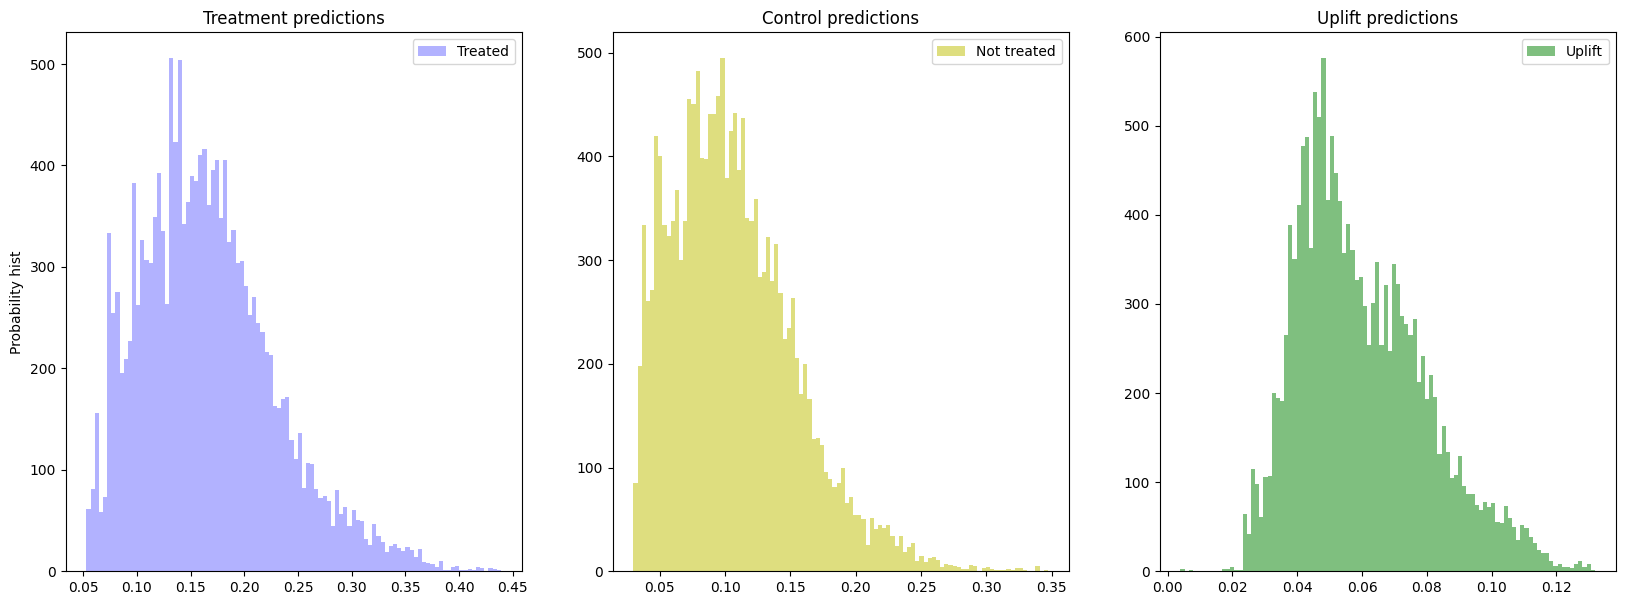

In [25]:
# Получаем условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисовываем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [26]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,20.158140
1,is_referral,19.326300
2,history,16.112031
3,recency,13.622265
4,used_bogo,11.129855
5,zip_code,7.430964
6,used_discount,6.582853
7,channel,5.637592


Трансформация классов

In [28]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [29]:
ct_score_10

0.09476318938476677

In [30]:
ct_score_20

0.07276731029306596

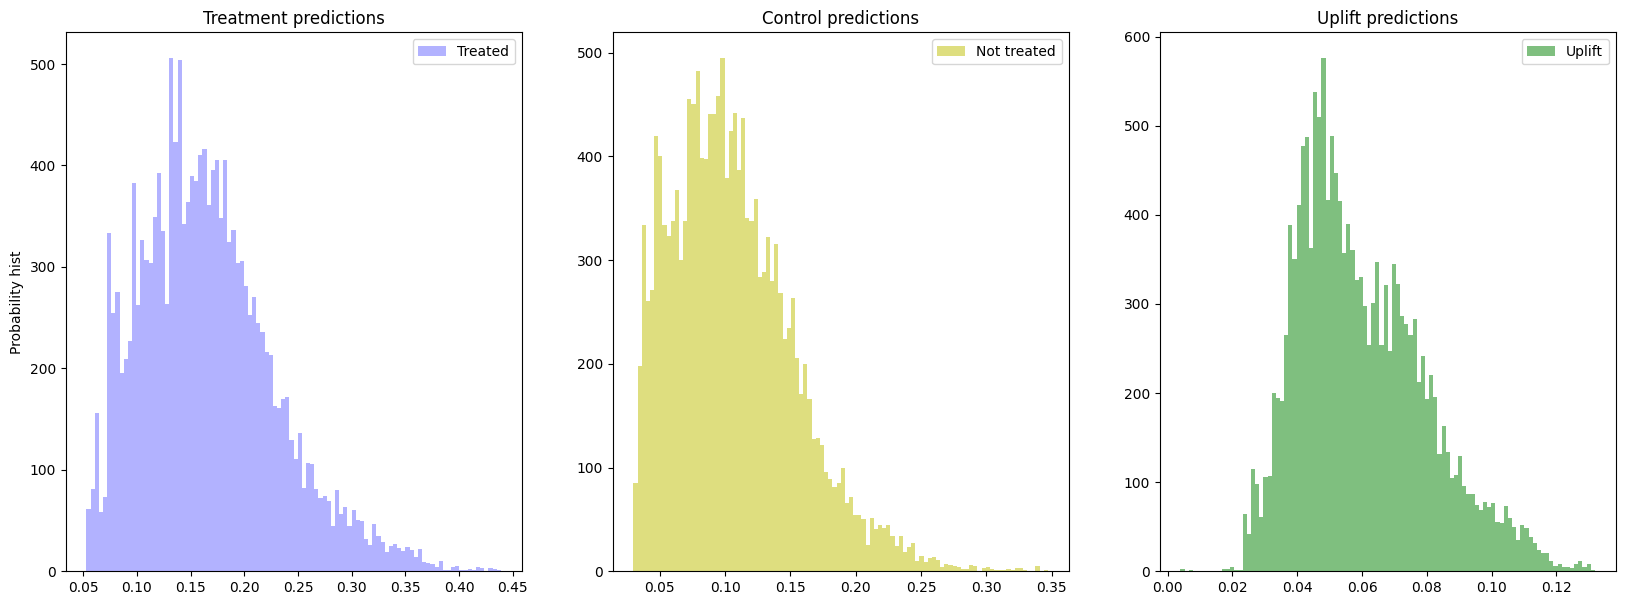

In [31]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

In [32]:
#важность признаков
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,37.272874
1,used_bogo,15.549789
2,recency,14.676112
3,zip_code,10.216740
4,channel,8.718982
5,used_discount,7.793967
6,is_referral,5.771535


array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

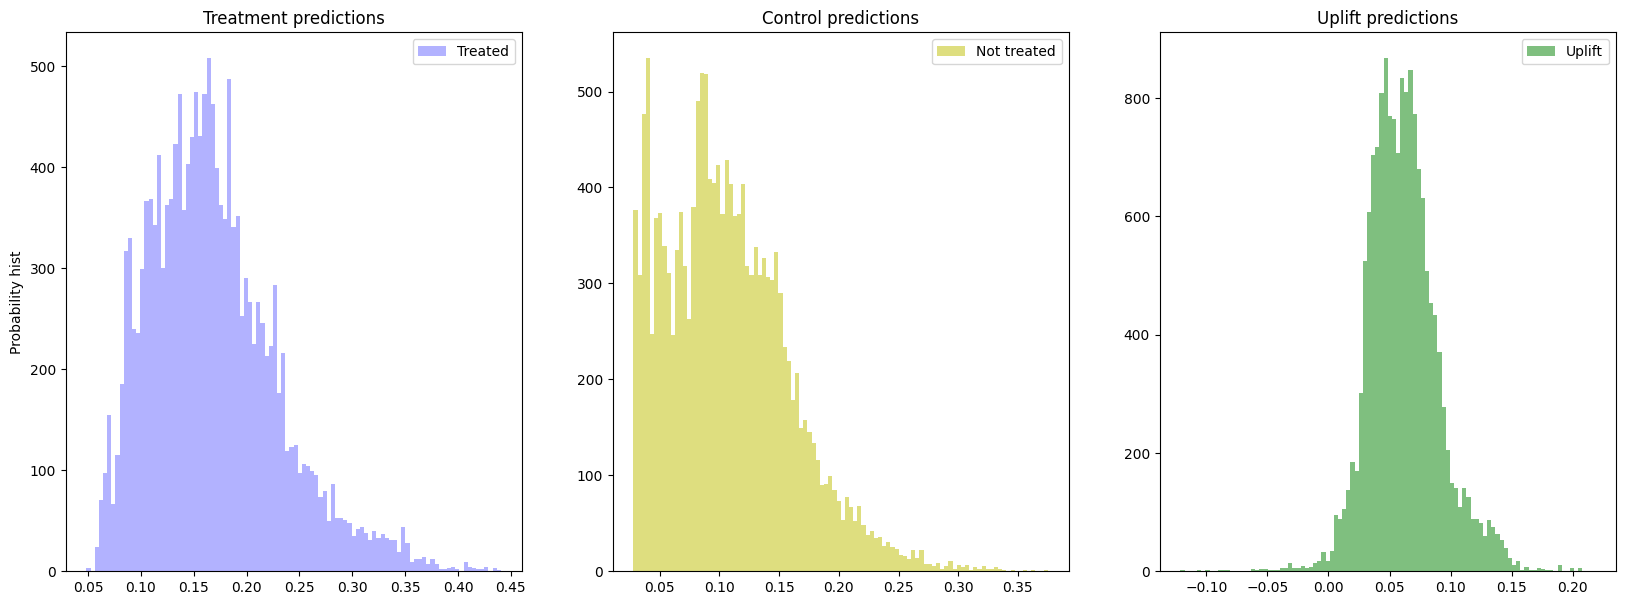

In [33]:
#2 модели
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True),
    estimator_ctrl=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [34]:
tm_score_10

0.09426046689466197

In [35]:
tm_score_20

0.07451444796114168

In [36]:
#важность признаков
tm_fi_trmnt = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score': tm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_trmnt

,feature_name,feature_score
0,history,22.548748
1,is_referral,19.763990
2,used_bogo,19.604718
3,recency,15.411624
4,used_discount,9.715265
5,zip_code,7.310287
6,channel,5.645368


In [37]:
#важность признаков для контрольной группы
tm_fi_ctrl = pd.DataFrame({
    'feature_name': tm.estimator_ctrl.feature_names_,
    'feature_score': tm.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_ctrl

,feature_name,feature_score
0,is_referral,32.570038
1,recency,21.598672
2,history,20.851448
3,zip_code,11.189940
4,channel,5.379672
5,used_discount,5.232895
6,used_bogo,3.177337


In [38]:
#единая таблица сравнения метрик

pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.094763,0.072767
2,TwoModels,0.094260,0.074514
0,SoloModel,0.074006,0.071739
